<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Objects_Counter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this project, the aim is to create an algorithm to detect objects on the video frames

In [ ]:
import os
import IPython
import numpy as np
import pandas as pd
import tensorflow as tf
IPython.display.clear_output()

#1

In [ ]:
image_size = (128, 128)
data = np.random.randint(5, 100, size=(1000, image_size[0], image_size[1]))
data[0]

array([[39,  7, 48, ..., 33, 61, 10],
       [47, 18,  5, ..., 36, 30, 79],
       [79, 68, 20, ..., 67, 20, 19],
       ...,
       [40, 34, 11, ..., 92,  9, 21],
       [18, 83, 10, ..., 30, 44, 67],
       [73, 67, 39, ..., 78, 62, 93]])

In [ ]:
def generate_synthetic_data(num_samples, image_size=(128, 128), num_objects_range=(5, 20)):
    data = []
    for _ in range(num_samples):
        num_objects = np.random.randint(*num_objects_range)
        image = np.zeros(image_size)
        for _ in range(num_objects):
            object_x = np.random.randint(0, image_size[1])
            object_y = np.random.randint(0, image_size[0])
            image[object_y, object_x] += 1
        data.append(image)
    return np.array(data)

# Prepare the data
num_samples = 1000
image_size = (128, 128)
input_data = generate_synthetic_data(num_samples, image_size)
density_maps = input_data.reshape(num_samples, image_size[0], image_size[1], 1)

In [ ]:
input_data.shape, density_maps.shape

((1000, 128, 128), (1000, 128, 128, 1))

In [ ]:
# Create the density map estimation model
def create_density_map_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    density_map = tf.keras.layers.Conv2D(1, (1, 1), activation='relu', padding='same')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=density_map)
    return model

In [ ]:
# Create and compile the model
input_shape = (image_size[0], image_size[1], 1)
model = create_density_map_model(input_shape)
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# Train the model
model.fit(input_data, density_maps, batch_size=32, epochs=10, validation_split=0.2)

# Test the model on a new image
test_image = generate_synthetic_data(1, image_size)[0]
predicted_density_map = model.predict(test_image.reshape(1, image_size[0], image_size[1], 1))

# Perform object counting by summing up the density map values
predicted_count = np.sum(predicted_density_map)

print(f"True object count: {test_image.sum()}")
print(f"Predicted object count: {predicted_count}")

#[link text](https://www.analyticsvidhya.com/blog/2021/11/complete-guide-to-people-counting-and-tracking-end-to-end-deep-learning-project/)


[link text](https://github.com/BakingBrains/People_counting_basic/blob/main/utils/centroidtracker.py)

In [1]:
import numpy as np
from collections import OrderedDict
from scipy.spatial import distance as dist

In [4]:
class TrackableObject:
	def __init__(self, objectID, centroid):
		self.objectID = objectID
		self.centroids = [centroid]
		self.counted = False

In [5]:
class CentroidTracker:
	def __init__(self, maxDisappeared=50, maxDistance=50):
		self.nextObjectID = 0
		self.objects = OrderedDict()
		self.disappeared = OrderedDict()
		self.maxDisappeared = maxDisappeared
		self.maxDistance = maxDistance

	def register(self, centroid):
		self.objects[self.nextObjectID] = centroid
		self.disappeared[self.nextObjectID] = 0
		self.nextObjectID += 1

	def deregister(self, objectID):
		del self.objects[objectID]
		del self.disappeared[objectID]

	def update(self, rects):
		if len(rects) == 0:
			for objectID in list(self.disappeared.keys()):
				self.disappeared[objectID] += 1

				if self.disappeared[objectID] > self.maxDisappeared:
					self.deregister(objectID)

			return self.objects

		inputCentroids = np.zeros((len(rects), 2), dtype="int")

		for (i, (startX, startY, endX, endY)) in enumerate(rects):
			cX = int((startX + endX) / 2.0)
			cY = int((startY + endY) / 2.0)
			inputCentroids[i] = (cX, cY)

		if len(self.objects) == 0:
			for i in range(0, len(inputCentroids)):
				self.register(inputCentroids[i])

		else:
			objectIDs = list(self.objects.keys())
			objectCentroids = list(self.objects.values())

			D = dist.cdist(np.array(objectCentroids), inputCentroids)

			rows = D.min(axis=1).argsort()

			cols = D.argmin(axis=1)[rows]

			usedRows = set()
			usedCols = set()

			for (row, col) in zip(rows, cols):
				if row in usedRows or col in usedCols:
					continue

				if D[row, col] > self.maxDistance:
					continue

				objectID = objectIDs[row]
				self.objects[objectID] = inputCentroids[col]
				self.disappeared[objectID] = 0

				usedRows.add(row)
				usedCols.add(col)

			unusedRows = set(range(0, D.shape[0])).difference(usedRows)
			unusedCols = set(range(0, D.shape[1])).difference(usedCols)

			if D.shape[0] >= D.shape[1]:
				for row in unusedRows:
					objectID = objectIDs[row]
					self.disappeared[objectID] += 1

					if self.disappeared[objectID] > self.maxDisappeared:
						self.deregister(objectID)

			else:
				for col in unusedCols:
					self.register(inputCentroids[col])

		return self.objects

In [ ]:
import cv2 as cv
import argparse
import sys
import numpy as np
import os.path
import math

confThreshold = 0.6
nmsThreshold = 0.4
inpWidth = 416
inpHeight = 416

parser = argparse.ArgumentParser(description='Object Detection using YOLO in OPENCV')

parser.add_argument('--video', default='test.mp4', help='Path to video file.')
args = parser.parse_args()

classesFile = "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

modelConfiguration = "yolov3.cfg"
modelWeights = "yolov3.weights"

print("[INFO] loading model...")
net = cv.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv.dnn.DNN_TARGET_OPENCL)

writer = None

W = None
H = None

ct = CentroidTracker(maxDisappeared=40, maxDistance=50)
trackers = []
trackableObjects = {}

totalDown = 0
totalUp = 0

def getOutputsNames(net):
    layersNames = net.getLayerNames()
    return [layersNames[i - 1] for i in net.getUnconnectedOutLayers()]


def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    rects = []

    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            classId = np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    indices = cv.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        if classIds[i] == 0:
            rects.append((left, top, left + width, top + height))
            objects = ct.update(rects)
            counting(objects)


def counting(objects):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    global totalDown
    global totalUp

    for (objectID, centroid) in objects.items():
        to = trackableObjects.get(objectID, None)

        if to is None:
            to = TrackableObject(objectID, centroid)

        else:
            y = [c[1] for c in to.centroids]
            direction = centroid[1] - np.mean(y)
            print(direction)
            to.centroids.append(centroid)

            if not to.counted:

                if direction < 0 and centroid[1] in range(frameHeight//2 - 30, frameHeight//2 + 30):
                    totalUp += 1
                    to.counted = True

                elif direction > 0 and centroid[1] in range(frameHeight//2 - 30, frameHeight//2 + 30):
                    totalDown += 1
                    to.counted = True

        trackableObjects[objectID] = to
        # text = "ID {}".format(objectID)
        # cv.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
            # cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
        cv.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
    info = [
        ("Up", totalUp),
        ("Down", totalDown),
    ]

    for (i, (k, v)) in enumerate(info):

        text = "{}".format(v)
        if k == 'Up':
            cv.putText(frame, f'Up : {text}', (10, 55),
                cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        if k == 'Down':
            cv.putText(frame, f'Down : {text}', (10, 75),
                       cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

winName = 'People Counting and Tracking System'
cv.namedWindow(winName, cv.WINDOW_NORMAL)

outputFile = "yolo_out_py.avi"

if (args.video):
    if not os.path.isfile(args.video):
        print("Input video file ", args.video, " doesn't exist")
        sys.exit(1)
    cap = cv.VideoCapture(args.video)
    outputFile = args.video[:-4]+'_output.avi'
else:
    cap = cv.VideoCapture(0)

vid_writer = cv.VideoWriter(outputFile, cv.VideoWriter_fourcc('M','J','P','G'), 30, (round(cap.get(cv.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

while cv.waitKey(1) < 0:

    hasFrame, frame = cap.read()
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    cv.line(frame, (0, frameHeight // 2), (frameWidth, frameHeight // 2), (0, 255, 255), 2)

    if not hasFrame:
        print("Done processing !!!")
        print("Output file is stored as ", outputFile)
        cv.waitKey(3000)
        cap.release()
        break

    blob = cv.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    net.setInput(blob)

    outs = net.forward(getOutputsNames(net))

    postprocess(frame, outs)

    t, _ = net.getPerfProfile()
    label = 'Inference time: %.2f ms' % (t * 1000.0 / cv.getTickFrequency())
    cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
    vid_writer.write(frame.astype(np.uint8))
    cv.imshow(winName, frame)



#[3](https://www.analyticsvidhya.com/blog/2021/12/vehicle-detection-and-counting-system-using-opencv/)

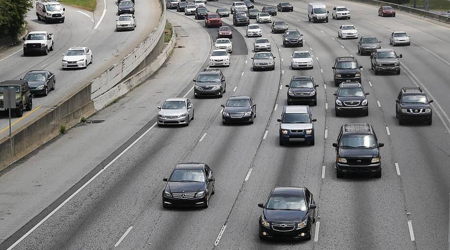

In [8]:
import cv2
import requests
import numpy as np
from PIL import Image

image = Image.open(requests.get('https://a57.foxnews.com/media.foxbusiness.com/BrightCove/854081161001/201805/2879/931/524/854081161001_5782482890001_5782477388001-vs.jpg', stream=True).raw)
image = image.resize((450,250))
image_arr = np.array(image)
image

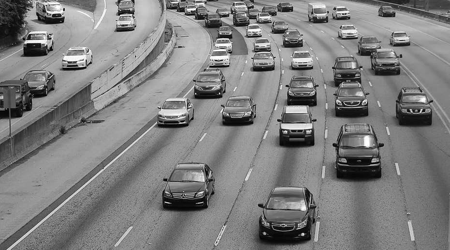

In [9]:
#GrayScale
grey = cv2.cvtColor(image_arr,cv2.COLOR_BGR2GRAY)
Image.fromarray(grey)

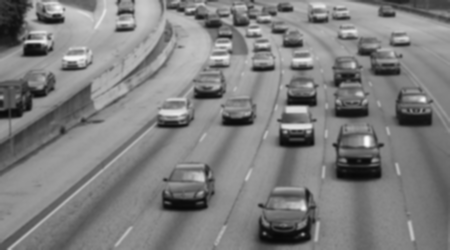

In [10]:
# Gaussian Blur
blur = cv2.GaussianBlur(grey,(5,5),0)
Image.fromarray(blur)

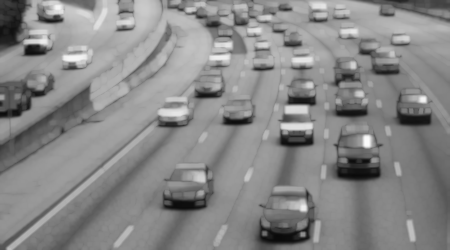

In [11]:
# Dilation
dilated = cv2.dilate(blur,np.ones((3,3)))
Image.fromarray(dilated)

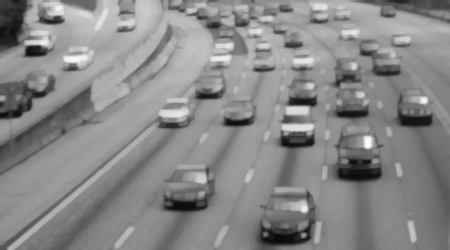

In [12]:
# Morphology-Ex, structuring element
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
closing = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
Image.fromarray(closing)

In [ ]:
!wget https://raw.githubusercontent.com/andrewssobral/vehicle_detection_haarcascades/master/cars.xml

In [18]:
car_cascade_src = '/content/cars.xml'
car_cascade = cv2.CascadeClassifier(car_cascade_src)
cars = car_cascade.detectMultiScale(closing, 1.1, 1)
cars

array([[376,   1,  22,  22],
       [245,  24,  20,  20],
       [307,   4,  27,  27],
       [196,  10,  28,  28],
       [ 35,   2,  30,  30],
       [274,  22,  37,  37],
       [250,  35,  25,  25],
       [ 13,  25,  43,  43],
       [101,   3,  43,  43],
       [ 62,  39,  23,  23],
       [224,  32,  30,  30],
       [ 52,  44,  39,  39],
       [237,  38,  49,  49],
       [362,  43,  46,  46],
       [256,  52,  79,  79],
       [317,  66,  66,  66],
       [209,  88,  54,  54],
       [384,  84,  59,  59],
       [145,  91,  53,  53],
       [268, 106,  60,  60],
       [318, 121,  82,  82],
       [150, 163,  68,  68]], dtype=int32)

In [15]:
cnt = 0
for (x,y,w,h) in cars:
    cv2.rectangle(image_arr,(x,y),(x+w,y+h),(255,0,0),2)
    cnt += 1
print(cnt, " cars found")
Image.fromarray(image_arr)

NameError: ignored